<a href="https://colab.research.google.com/github/aadmberrada/WalmartSales/blob/main/DTS_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Import

In [333]:
pip install catboost

In [334]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', 100)
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import time
import xgboost
from xgboost import XGBRegressor 
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import re



In [335]:
PATH = "/content/drive/MyDrive/DTS/walmart-recruiting-store-sales-forecasting"

train = pd.read_csv(PATH+ "/train.csv")
features = pd.read_csv(PATH+ "/features.csv")
stores = pd.read_csv(PATH+ "/stores.csv")
ss = pd.read_csv(PATH+ "/sampleSubmission.csv")

# 1 - Présentation des jeux de données

In [336]:
train = train.drop("IsHoliday", axis = 1)
train.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90


In [337]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [338]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [339]:
df = pd.merge(left = train, right = features ,on = ['Date', "Store"], how = 'inner')
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [340]:
#df.to_csv(PATH + '/bdd_merged.csv')

# 3 - Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

Voir Dashboards

# 4 - Features Engineering

Création de plusieurs variables

In [341]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df['year'] = df["Date"].dt.year
df['month'] = df["Date"].dt.month
df['day'] = df["Date"].dt.day
df['week'] = df["Date"].dt.week

In [342]:
# Création lags (days)
# Lag 
for lag in list(range(4, 25, 4)):
    df['Weekly_Sales_'+str(lag)] = df.groupby(
        ['Store',	'Dept'], 
        as_index = False)['Weekly_Sales'].shift(lag).astype(np.float64)
#df = df.drop("Weekly_Sales_0", axis = 1)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,year,month,day,week,Weekly_Sales_4,Weekly_Sales_8,Weekly_Sales_12,Weekly_Sales_16,Weekly_Sales_20,Weekly_Sales_24
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN


## A supprimer

In [140]:
df.set_index("month").index

Int64Index([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
            ...
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
           dtype='int64', name='month', length=421570)

In [12]:
df[(df["Store"]==1) & (df["Dept"]==1)]

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,year,month,day,week,Weekly_Sales_4,Weekly_Sales_8,Weekly_Sales_12,Weekly_Sales_16,Weekly_Sales_20,Weekly_Sales_24
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
73,1,1,2010-02-12,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,...,2010,2,12,6,NaN,NaN,NaN,NaN,NaN,NaN
145,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,...,2010,2,19,7,NaN,NaN,NaN,NaN,NaN,NaN
218,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,...,2010,2,26,8,NaN,NaN,NaN,NaN,NaN,NaN
290,1,1,2010-03-05,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,...,2010,3,5,9,24924.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,1,1,2012-09-28,18947.81,76.08,3.666,3666.27,7.64,1.65,1417.96,...,2012,9,28,39,16680.24,16628.31,17823.37,17666.00,18164.20,34684.21
9956,1,1,2012-10-05,21904.47,68.55,3.617,8077.89,NaN,18.22,3617.43,...,2012,10,5,40,18322.37,16119.92,16566.18,17558.82,18517.79,16976.19
10028,1,1,2012-10-12,22764.01,62.99,3.601,2086.18,NaN,8.11,602.36,...,2012,10,12,41,19616.22,17330.70,16348.06,16633.41,16963.55,16347.60
10101,1,1,2012-10-19,24185.27,67.97,3.594,950.33,NaN,4.93,80.25,...,2012,10,19,42,19251.50,16286.40,15731.18,15722.82,16065.49,17147.44


In [145]:
df["month"] = str(0) + df["month"].astype(str)

In [146]:
df["dd"]= df["year"].astype(str) + df["month"] 

In [148]:
df = df.set_index("dd")

In [149]:
df.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
dd,,,,,,,,,,,,,,,,,,,,,
201002,1,1,24924.50,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.5,24924.5,21710.543621,19213.485088,22513.322937,0,0,0,0,1
201002,1,2,50605.27,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.5,24924.5,21710.543621,43607.020113,46102.090420,0,0,0,0,1
201002,1,3,13740.12,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.5,24924.5,21710.543621,11793.698516,13150.478042,0,0,0,0,1
201002,1,4,39954.04,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.5,24924.5,21710.543621,25974.630238,36964.154476,0,0,0,0,1
201002,1,5,32229.38,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.5,24924.5,21710.543621,21365.583515,24257.941119,0,0,0,0,1


## A supprimer

Création de variables

In [343]:
df['Store_sales_avg'] = df.groupby('Store')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Dept_sales_avg'] = df.groupby('Dept')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Store_Dept_sales_avg'] = df.groupby(['Store','Dept'])['Weekly_Sales'].transform('mean').astype(np.float64)

df = df.replace(np.inf, np.nan)

Creéation de variables

In [344]:
df['Super_Bowl']   =  np.where(((df['Date'] == "2010-02-10") | (df['Date'] == "2011-02-11") | 
                                (df['Date'] == "2012-02-10") | (df['Date'] == "2013-02-08")), 1, 0)

df['Labor_day']    =  np.where(((df['Date'] == "2010-09-10") | (df['Date'] == "2011-09-09") | 
                                (df['Date'] == "2012-09-07") | (df['Date'] == "2013-09-06")), 1, 0)

df['Thanksgiving'] =  np.where(((df['Date'] == "2010-11-26") | (df['Date'] == "2011-11-25") | 
                                (df['Date'] == "2012-11-23") | (df['Date'] == "2013-11-29")), 1, 0)

df['Christmas']    =  np.where(((df['Date'] == "2010-12-31") | (df['Date'] == "2011-12-30") | 
                                (df['Date'] == "2012-12-28") | (df['Date'] ==  "2013-12-27")),1, 0)

In [345]:
df["Benefice"] = np.where(df["Weekly_Sales"]>0, 1, 0)

df["Benefice"].value_counts()

1    420212
0      1358
Name: Benefice, dtype: int64

1358 sans avoir de bénéfice

# 5 -Data Cleaning

In [346]:
(df.isna().sum()/df.shape[0]).sort_values(ascending = False)

MarkDown2               0.736110
MarkDown4               0.679847
MarkDown3               0.674808
MarkDown1               0.642572
MarkDown5               0.640790
Weekly_Sales_24         0.179795
Weekly_Sales_20         0.150623
Weekly_Sales_16         0.121237
Weekly_Sales_12         0.091598
Weekly_Sales_8          0.061594
Weekly_Sales_4          0.031155
Store_Dept_sales_avg    0.000000
Dept_sales_avg          0.000000
Store_sales_avg         0.000000
Super_Bowl              0.000000
Labor_day               0.000000
Thanksgiving            0.000000
Christmas               0.000000
Store                   0.000000
day                     0.000000
week                    0.000000
Dept                    0.000000
month                   0.000000
year                    0.000000
IsHoliday               0.000000
Unemployment            0.000000
CPI                     0.000000
Fuel_Price              0.000000
Temperature             0.000000
Weekly_Sales            0.000000
Date      

On va supprimer les colonnes avec plus de 60% de NaN

In [347]:
df.columns[df.isna().sum()/df.shape[0]>0.6]

Index(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], dtype='object')

In [348]:
to_del = list(df.columns[df.isna().sum()/df.shape[0]>0.6])
df = df.drop(to_del, axis = 1)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,year,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,19213.485088,22513.322937,0,0,0,0,1
1,1,2,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,43607.020113,46102.090420,0,0,0,0,1
2,1,3,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,11793.698516,13150.478042,0,0,0,0,1
3,1,4,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,25974.630238,36964.154476,0,0,0,0,1
4,1,5,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,21365.583515,24257.941119,0,0,0,0,1


In [349]:
(df.isna().sum()).sort_values(ascending = False)

Weekly_Sales_24         75796
Weekly_Sales_20         63498
Weekly_Sales_16         51110
Weekly_Sales_12         38615
Weekly_Sales_8          25966
Weekly_Sales_4          13134
Christmas                   0
Thanksgiving                0
Labor_day                   0
Super_Bowl                  0
Store_Dept_sales_avg        0
Dept_sales_avg              0
Store_sales_avg             0
Store                       0
Dept                        0
week                        0
day                         0
month                       0
year                        0
IsHoliday                   0
Unemployment                0
CPI                         0
Fuel_Price                  0
Temperature                 0
Weekly_Sales                0
Date                        0
Benefice                    0
dtype: int64

Pour les NaN, on utilise la méthode du Backward fill : on remplace les valeurs
manquantes dans le passé en se basant sur la première valeur connue après les manquantes. On l'utilise car les variables avec les NaN sont des Variables laguées.

In [350]:
for col in df.columns :
  if col.startswith("Weekly_Sales_"):
    df[col]  = df[col].bfill(axis ='rows')

In [351]:
df.isna().sum()

Store                   0
Dept                    0
Date                    0
Weekly_Sales            0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
IsHoliday               0
year                    0
month                   0
day                     0
week                    0
Weekly_Sales_4          0
Weekly_Sales_8          0
Weekly_Sales_12         0
Weekly_Sales_16         0
Weekly_Sales_20         0
Weekly_Sales_24         0
Store_sales_avg         0
Dept_sales_avg          0
Store_Dept_sales_avg    0
Super_Bowl              0
Labor_day               0
Thanksgiving            0
Christmas               0
Benefice                0
dtype: int64

In [352]:
df = df.set_index(df["Date"])
df = df.drop(["Date","IsHoliday"], axis = 1)

In [353]:
df.shape

(421570, 25)

# 6 - Préparation des données

# 7 - Sélection de différents modèles (explications des critères de sélection, choix de la métrique, …)

### 7 - 0 - Fn

In [ ]:
#stores = df.Store.unique()

In [ ]:
#df = df.loc[:'2010-06-30']
#On prend 6 mois
df.shape

(421570, 25)

In [ ]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'week', 'Weekly_Sales_4',
       'Weekly_Sales_8', 'Weekly_Sales_12', 'Weekly_Sales_16',
       'Weekly_Sales_20', 'Weekly_Sales_24', 'Store_sales_avg',
       'Dept_sales_avg', 'Store_Dept_sales_avg', 'Super_Bowl', 'Labor_day',
       'Thanksgiving', 'Christmas', 'Benefice'],
      dtype='object')

In [161]:
df[df['year']==2010].index.unique()

Index(['201002', '201003', '201004', '201005', '201006', '201007', '201008',
       '201009', '2010010', '2010011', '2010012'],
      dtype='object', name='dd')

Pour la taille du train set, on va récupérer les données jusqu'en fin 2011. Donc on prend en compte 2 années pour chaque Store.

Le test set sera l'année 2012

In [162]:
df[df['year']==2012].index.unique()

Index(['201201', '201202', '201203', '201204', '201205', '201206', '201207',
       '201208', '201209', '2012010'],
      dtype='object', name='dd')

### Partie à détailler

In [249]:
df

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
dd,,,,,,,,,,,,,,,,,,,,,
201002,1,1,24924.50,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.50,24924.50,21710.543621,19213.485088,22513.322937,0,0,0,0,1
201002,1,2,50605.27,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.50,24924.50,21710.543621,43607.020113,46102.090420,0,0,0,0,1
201002,1,3,13740.12,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.50,24924.50,21710.543621,11793.698516,13150.478042,0,0,0,0,1
201002,1,4,39954.04,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.50,24924.50,21710.543621,25974.630238,36964.154476,0,0,0,0,1
201002,1,5,32229.38,42.31,2.572,211.096358,8.106,2010,02,5,...,24924.50,24924.50,21710.543621,21365.583515,24257.941119,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012010,45,93,2487.80,58.85,3.882,192.308899,8.667,2012,010,26,...,4189.70,3034.74,11662.897315,27008.060746,2728.627133,0,0,0,0,1
2012010,45,94,5203.31,58.85,3.882,192.308899,8.667,2012,010,26,...,3226.48,3800.78,11662.897315,33405.883963,3690.272090,0,0,0,0,1
2012010,45,95,56017.47,58.85,3.882,192.308899,8.667,2012,010,26,...,57202.30,51925.15,11662.897315,69824.423080,52896.166643,0,0,0,0,1


In [61]:
#((df.index=='2011-12-30').any() == True) & ((df.index=='2012-01-06').any()  == True) 

True

In [180]:
def test_(test):
  X_test  = test.drop("Weekly_Sales", axis = 1)
  X_test_ = scaler.transform(X_test)
  X_test  = pd.DataFrame(X_test_, columns = X_test.columns)
  y_test  = test["Weekly_Sales"]
  X_test  = X_test.set_index(y_test.index)
  y_test =  test["Weekly_Sales"]
  return test, X_test, y_test

def train_(train):
  scaler = MinMaxScaler()
  X_train = train.drop("Weekly_Sales", axis = 1)
  X_train_ = scaler.fit_transform(X_train)
  X_train = pd.DataFrame(X_train_, columns = X_train.columns)

  y_train = train["Weekly_Sales"]
  return train, X_train, y_train

In [ ]:
df[df["year"].isin([2010, 2011])]

In [ ]:
#d_test

In [ ]:
(importance_dept.columns).sort_values()

In [114]:
#df.Dept.unique()

In [113]:
#importance_dept

Dates pas régulières

In [88]:
#df[(df["Store"]==45) & (df["Dept"]==96)].index

DatetimeIndex(['2012-03-16', '2012-09-14'], dtype='datetime64[ns]', name='Date', freq=None)

In [268]:
d_test["Dept"].unique()

81

In [122]:
d_train[d_train["Store"]==1]["Dept"].unique()

array([47, 51, 78, 99, 77])

## Debut

In [282]:
def model_(model):
  importance_dept = pd.DataFrame()
  importance_store = pd.DataFrame()
  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()

  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      try:
        train, X_train, y_train = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass

      # Validation Prediction
      try:
        test, X_test, y_test = test_(df__[df__["year"]==2012])
      except:
        pass

      model = model
    

      # Fit model
      model.fit(X_train, y_train)

      test_pred = model.predict(X_test)
      pred = pd.DataFrame(test_pred)
      pred = pred.set_index(y_test.index)
      predictions_test = pd.concat([y_test, pred], axis = 1)
      predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
      predictions_test["Store"] = store
      predictions_test["Dept"] = dept
      predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

      test_pred_train = model.predict(X_train)
      pred_train = pd.DataFrame(test_pred_train)
      pred_train = pred_train.set_index(y_train.index)
      predictions_train = pd.concat([y_train, pred_train], axis = 1)
      predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
      predictions_train["Store"] = store
      predictions_train["Dept"] = dept
      predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

      d_test = pd.concat([d_test, predictions_test], axis = 0)
      d_train = pd.concat([d_train, predictions_train], axis = 0)

      
      importance_dept["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
      importance_dept["importance_dept_"+str(dept)] = model.feature_importances_


    importance_store["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_store["importance_store_"+str(store)] = np.mean(importance_dept[[col for col in importance_dept.columns if col!= "features"]], axis = 1)

  importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
  importance_df["importance"] = np.mean(importance_store[[col for col in importance_store.columns if col!= "features"]], axis = 1)

  importance_df = importance_df[["features", "importance"]]

  t2 = time.time() - t1

    #assert d_test.shape[0]  == df[df['year']==2012].shape[0]
    #assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")

  return model, d_test, d_train, importance_df, t2

In [283]:
def metrics_(predictions_test, predictions_train):

  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)
  print(" -------> RMSE")
  print(" <--> Train : "+str(round(np.sqrt(mean_squared_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train'])),2)))
  print(" <--> Test  : "+str(round(np.sqrt(mean_squared_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test'])),2)))
  print("\n")
  print(" -------> MAE")
  print(" <--> Train : "+str(round(mean_absolute_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train']),2)))
  print(" <--> Test  : "+str(round(mean_absolute_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test']),2)))
  return metrics


In [284]:
def plot_metrics(metrics, model): 


  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - RMSE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["RMSE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["RMSE_train"].values)
  axes[1].set_title("Train")
  plt.show()

  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - MAE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["MAE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["MAE_train"].values)
  axes[1].set_title("Train")
  plt.show()


In [285]:
def imp_plot(importance_df, model):

  print(" ---- Features Importance")
  plt.figure(figsize=(30, 5))
  sns.barplot(x = "features", y = "importance", data = importance_df.sort_values(by="importance", ascending=False))
  plt.xticks(rotation=75)
  plt.title(str(re.findall(r"\w+", str(model))[0]) + " - Importance moyenne des différentes variables")
  plt.show()


  
  

#### Benchmark

In [315]:
def benchmark():
  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test, d_train = pd.DataFrame(), pd.DataFrame()
  metrics = {}

  t1 = time.time()

  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      try:
        train, X_train, y_train = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass

      # Validation Prediction
      try:
        test, X_test, y_test = test_(df__[df__["year"]==2012])
      except:
        pass

      model =  LinearRegression()

      # Fit model
      model.fit(X_train, y_train)

      test_pred = model.predict(X_test)
      pred = pd.DataFrame(test_pred)
      pred = pred.set_index(y_test.index)
      predictions_test = pd.concat([y_test, pred], axis = 1)
      predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
      predictions_test["Store"] = store
      predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

      test_pred_train = model.predict(X_train)
      pred_train = pd.DataFrame(test_pred_train)
      pred_train = pred_train.set_index(y_train.index)
      predictions_train = pd.concat([y_train, pred_train], axis = 1)
      predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
      predictions_train["Store"] = store
      predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

      d_test = pd.concat([d_test, predictions_test], axis = 0)
      d_train = pd.concat([d_train, predictions_train], axis = 0)


      importance_dept["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
      importance_dept["Coefficients_"+str(dept)] = model.coef_


    importance_store["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_store["Coefficients_store_"+str(store)] = np.mean(importance_dept[[col for col in importance_dept.columns if col!= "features"]], axis = 1)

  importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
  importance_df["importance"] = np.mean(importance_store[[col for col in importance_store.columns if col!= "features"]], axis = 1)

  importance_df = importance_df[["features", "importance"]]
  t2 = time.time() - t1

  #assert d_test.shape[0]  == df[df['year']==2012].shape[0]
  #assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")
  return model, d_test, d_train, importance_df, t2

model_lr, d_test_lr, d_train_lr, importance_df_lr, t2_lr = benchmark()


Succès !
L'opération a duré 107.32 sec


In [316]:
metrics_lr = metrics_(d_test_lr, d_train_lr)

 -------> RMSE
 <--> Train : 4044.54
 <--> Test  : 1417924.28


 -------> MAE
 <--> Train : 1704.37
 <--> Test  : 204805.92


In [317]:
round(metrics_lr,2)

,Store,RMSE_train,RMSE_test,MAE_train,MAE_test,RMSE_PCT_train,RMSE_PCT_test
0,1,3851.99,447372.16,1941.70,197967.28,17.91,494.97
1,2,5666.08,944533.94,2717.79,319596.22,20.92,439.23
2,3,1641.06,184013.36,711.34,40247.92,26.24,503.18
3,4,6106.90,7079458.17,2749.07,1175949.99,21.20,-1154.16
4,5,1168.45,25653.18,549.26,11329.26,23.52,210.08
5,6,4662.64,663966.57,2352.62,232079.19,21.14,461.98
6,7,2318.19,229977.18,1110.04,83573.11,28.10,-2538.45
7,8,2845.40,225038.98,1403.13,84974.26,21.72,318.55
8,9,2027.22,130085.19,981.21,47504.86,23.27,413.37
9,10,7250.89,4873594.98,2941.62,1094317.08,27.18,-2260.14


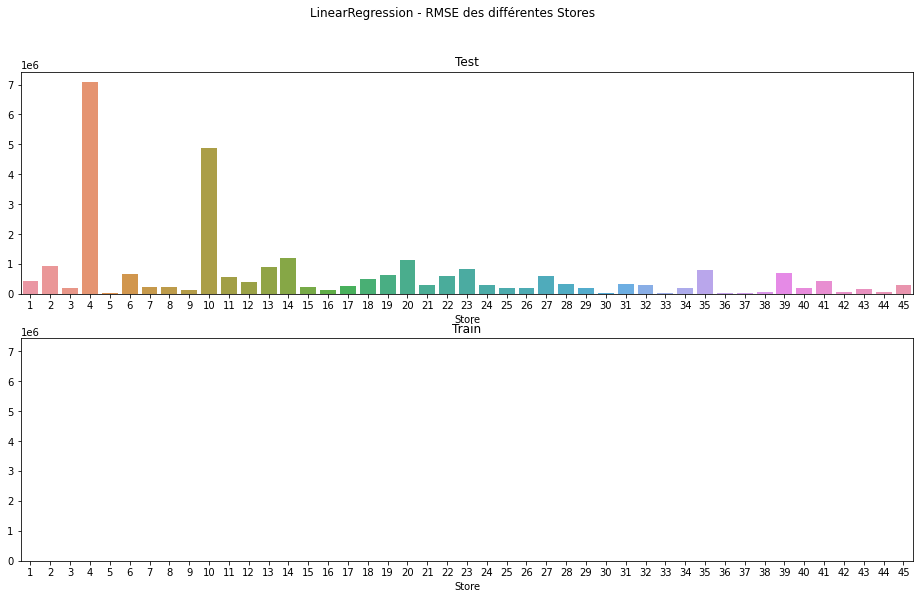

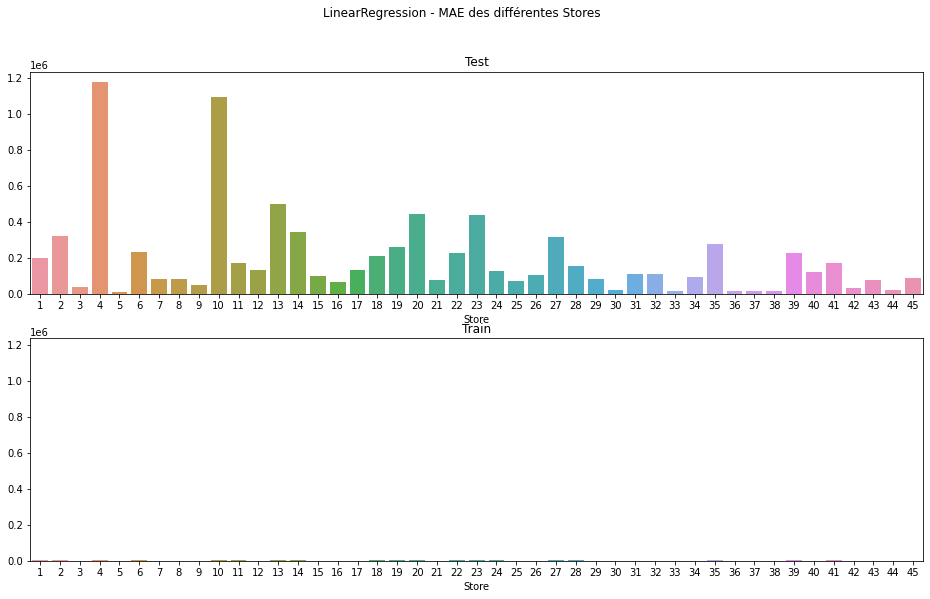

In [318]:
plot_metrics(metrics_lr, model_lr)

 ---- Features Importance


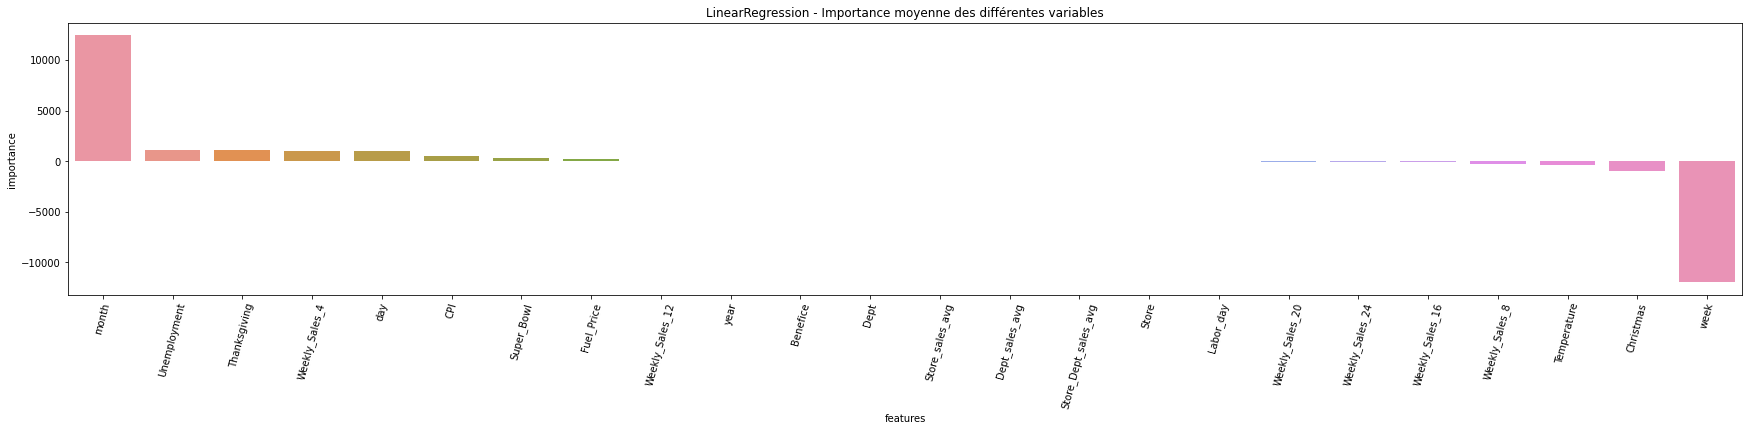

In [319]:
imp_plot(importance_df_lr, model_lr)

#### 1 - 1 - LGBMRegressor

In [ ]:

            n_estimators=100,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300)


In [302]:
model_lgbm, d_test_lgbm, d_train_lgbm, importance_df_lgbm, t2_lgbm = model_(
  model = LGBMRegressor())



Succès !
L'opération a duré 151.78 sec


 -------> RMSE
 <--> Train : 3765.56
 <--> Test  : 5390.24


 -------> MAE
 <--> Train : 1114.8
 <--> Test  : 2573.21


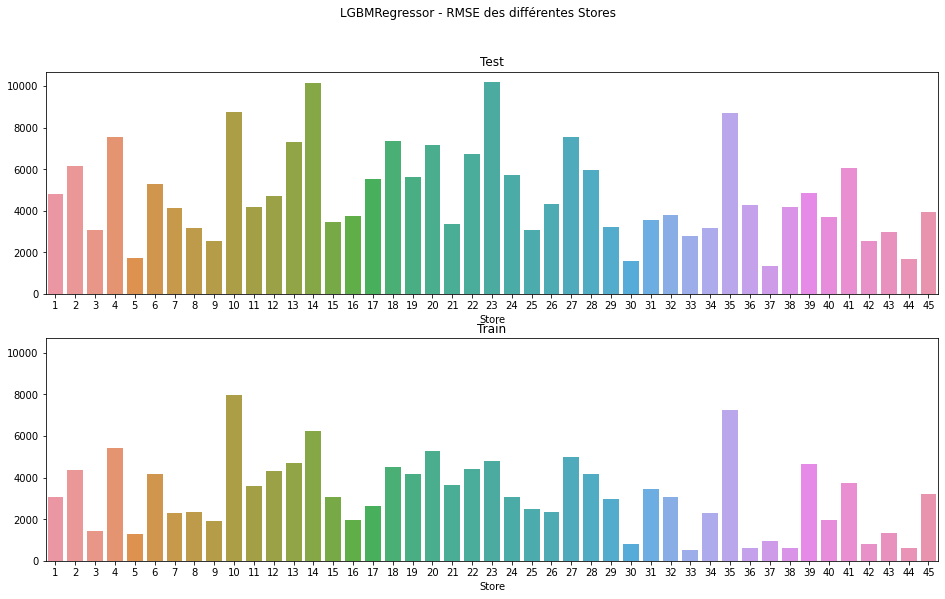

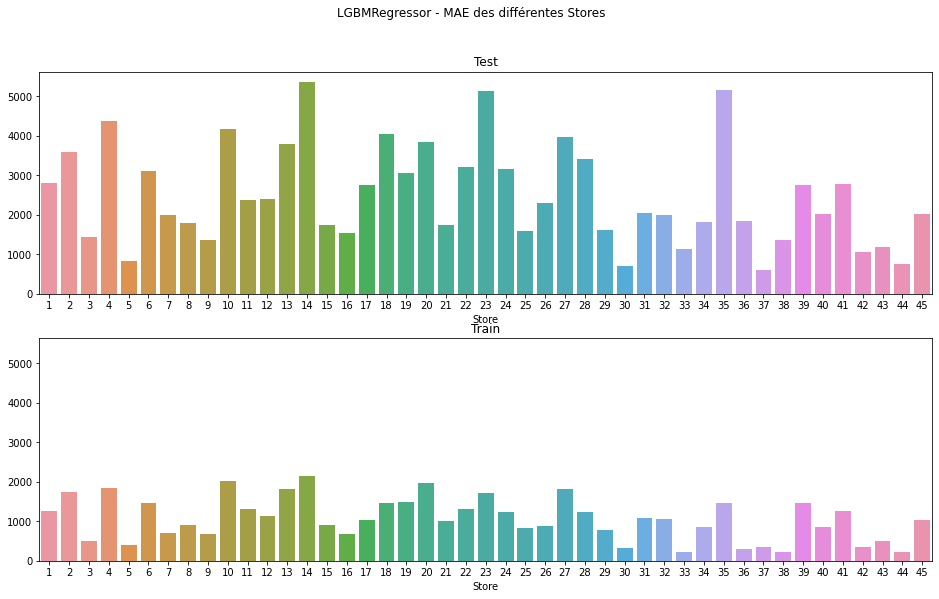

In [303]:
metrics_lgbm = metrics_(d_test_lgbm, d_train_lgbm)
plot_metrics(metrics_lgbm, model_lgbm)

 ---- Features Importance


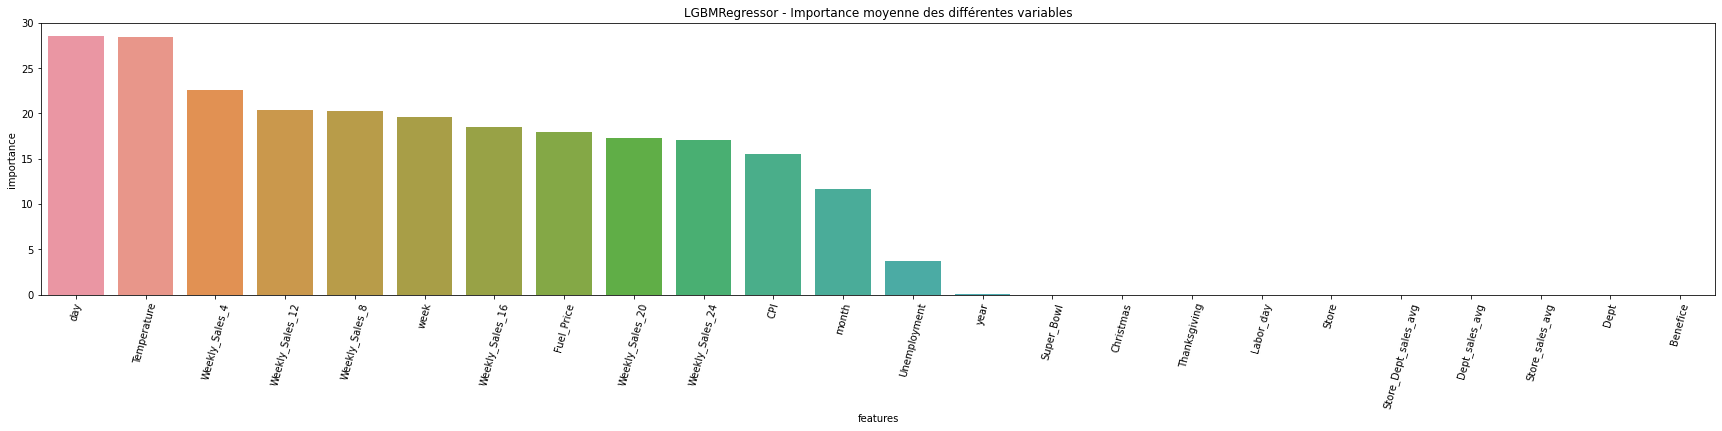

In [304]:
imp_plot(importance_df_lgbm, model_lgbm)

#### 1 - 2 - RandomForestRegressor


In [286]:
model_rf, d_test_rf, d_train_rf,importance_df_rf, t2_rf = model_(
  model = RandomForestRegressor())


Succès !
L'opération a duré 832.67 sec


 -------> RMSE
 <--> Train : 1733.53
 <--> Test  : 8449.45


 -------> MAE
 <--> Train : 613.45
 <--> Test  : 3431.36


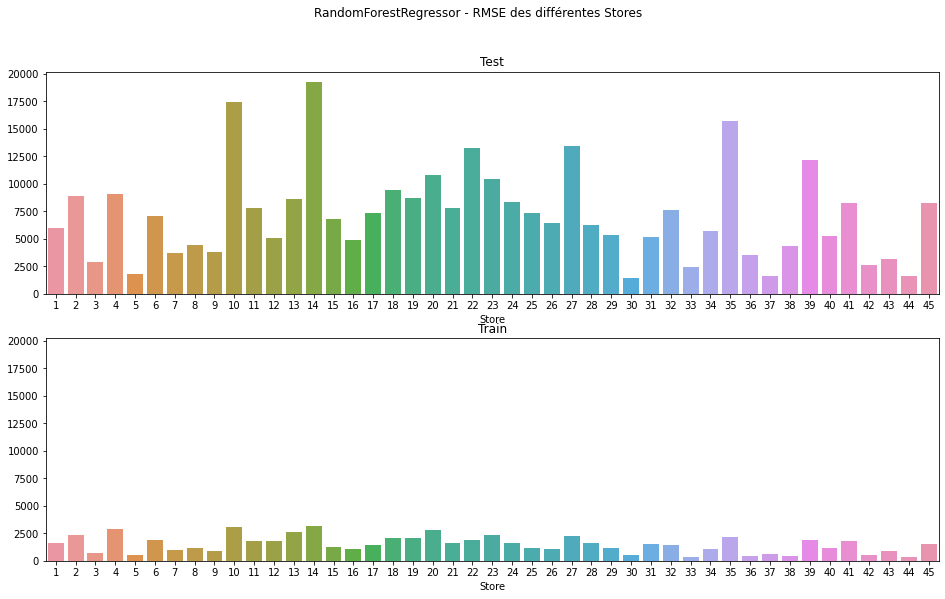

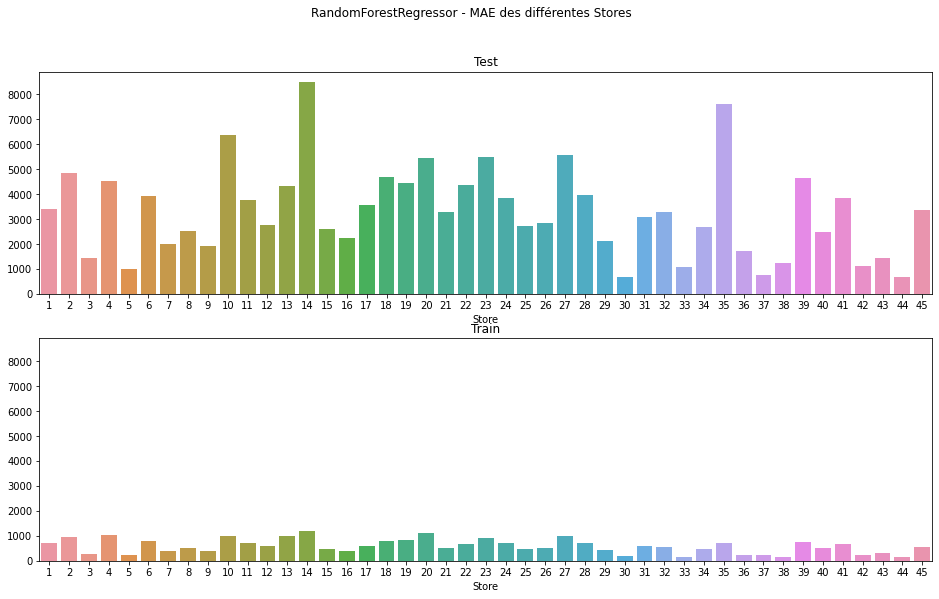

In [287]:
metrics_rf = metrics_(d_test_rf, d_train_rf)
plot_metrics(metrics_rf, model_rf)

 ---- Features Importance


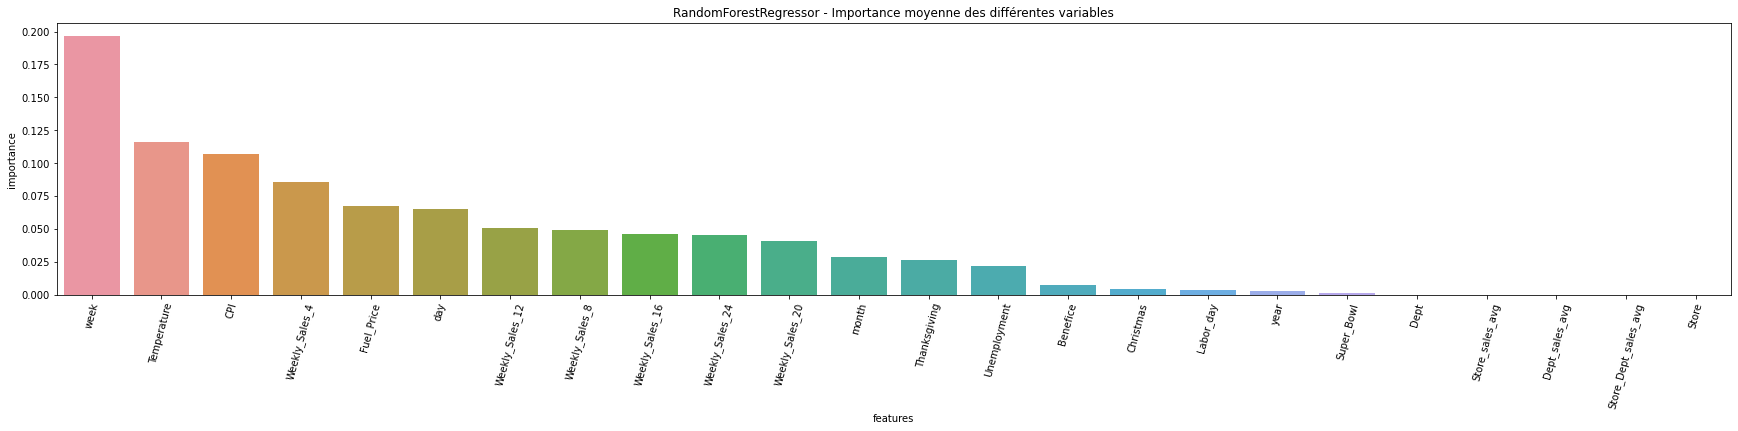

In [288]:
imp_plot(importance_df_rf, model_rf)

#### 1 - 3 - CatboostRegressor

In [289]:
pip install catboost

In [290]:
model_ctb, d_test_ctb, d_train_ctb,importance_df_ctb, t2_ctb = model_(
  model = CatBoostRegressor())


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4:	learn: 1121.7237121	total: 7.14ms	remaining: 1.42s
5:	learn: 1106.3646210	total: 8.56ms	remaining: 1.42s
6:	learn: 1091.6313461	total: 10.2ms	remaining: 1.45s
7:	learn: 1076.9083824	total: 11.9ms	remaining: 1.47s
8:	learn: 1063.9975076	total: 13.4ms	remaining: 1.48s
9:	learn: 1051.4700309	total: 15ms	remaining: 1.48s
10:	learn: 1039.8327467	total: 16.6ms	remaining: 1.49s
11:	learn: 1025.2583121	total: 18ms	remaining: 1.49s
12:	learn: 1011.7146216	total: 19.6ms	remaining: 1.49s
13:	learn: 998.1436871	total: 21.2ms	remaining: 1.49s
14:	learn: 984.6259766	total: 22.9ms	remaining: 1.5s
15:	learn: 971.6537591	total: 24.5ms	remaining: 1.5s
16:	learn: 960.1588080	total: 25.9ms	remaining: 1.5s
17:	learn: 947.3244384	total: 27.5ms	remaining: 1.5s
18:	learn: 938.1775942	total: 28.9ms	remaining: 1.49s
19:	learn: 926.9990474	total: 30.3ms	remaining: 1.49s
20:	learn: 915.6522566	total: 31.9ms	remaining: 1.49s
21:	learn

CatBoostError: ignored

In [291]:
metrics_ctb = metrics_(d_test_ctb, d_train_ctb)
plot_metrics(metrics_ctb, model_ctb)

NameError: ignored

In [ ]:
imp_plot(importance_df_ctb, model_ctb)

#### 1 - 4 - XgBoostRegressor

In [292]:
model_xgb, d_test_xgb, d_train_xgb,importance_df_xgb, t2_xgb = model_(
  model = XGBRegressor(objective="reg:squarederror"))

Succès !
L'opération a duré 203.46 sec


 -------> RMSE
 <--> Train : 611.99
 <--> Test  : 8136.12


 -------> MAE
 <--> Train : 293.35
 <--> Test  : 3198.84


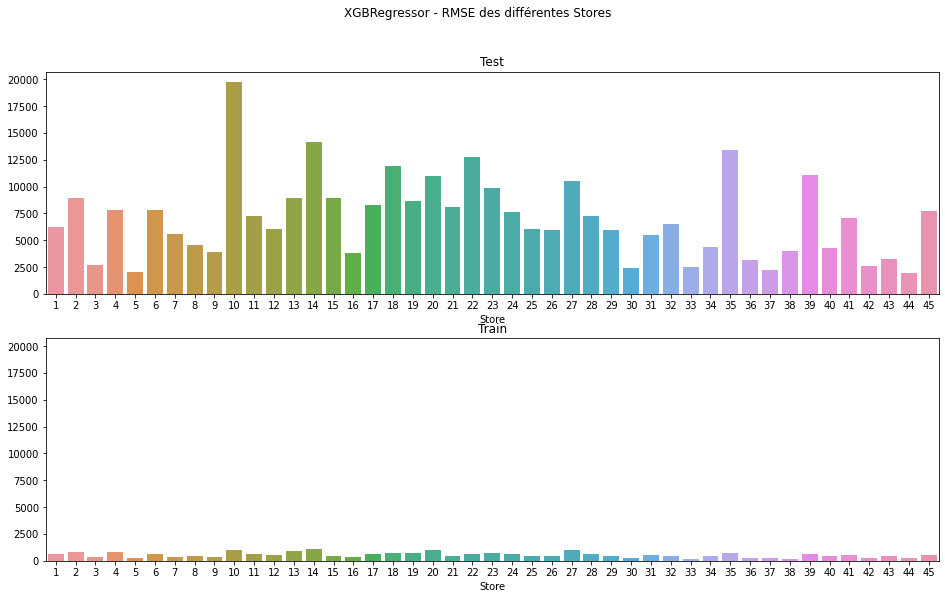

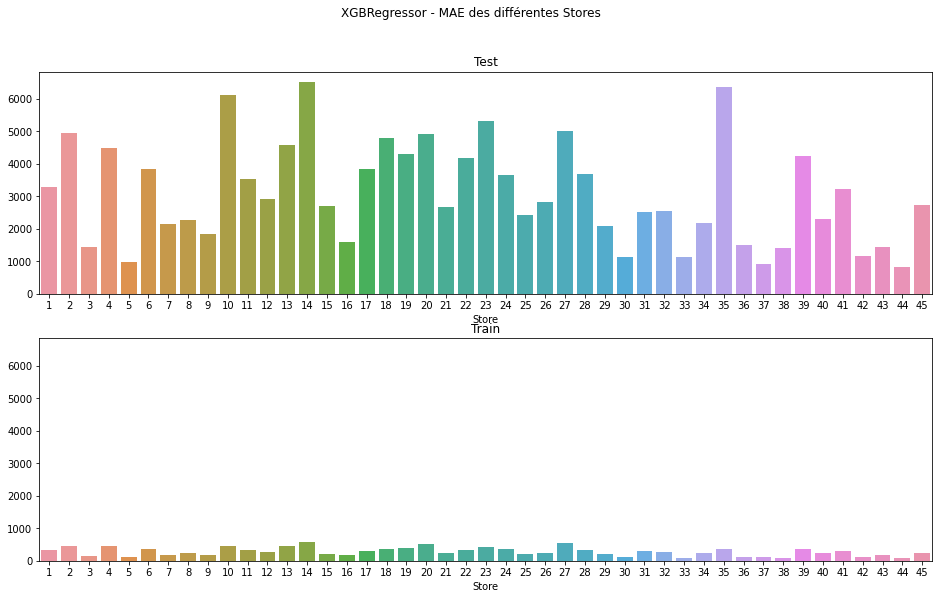

In [293]:
metrics_xgb = metrics_(d_test_xgb, d_train_xgb)
plot_metrics(metrics_xgb, model_xgb)

 ---- Features Importance


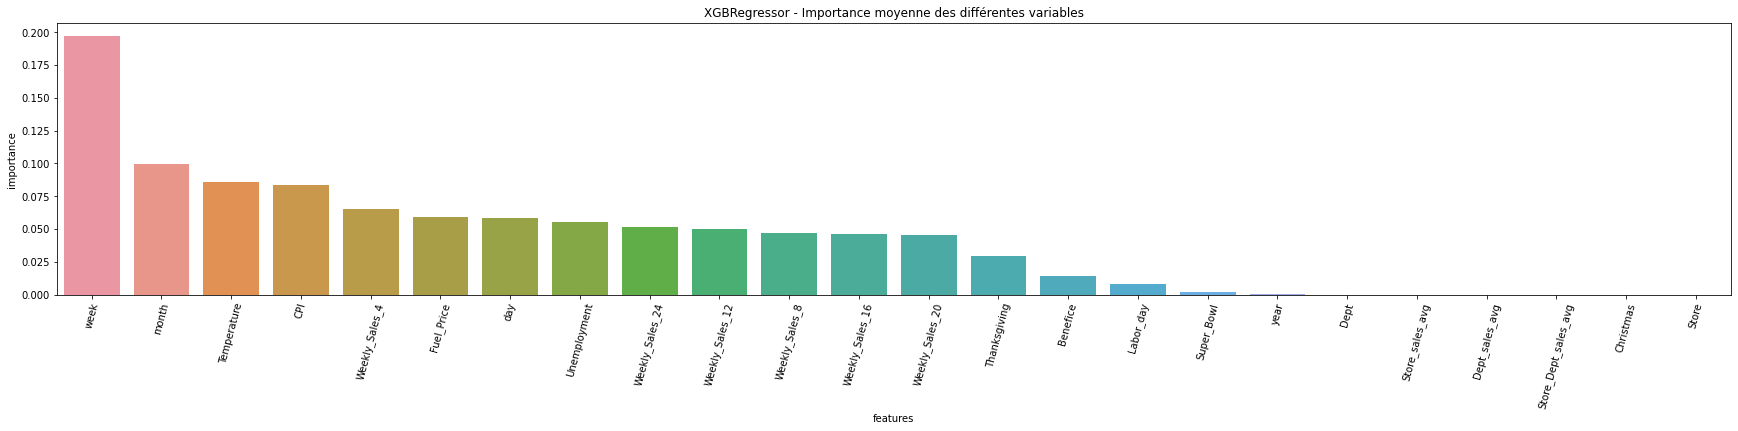

In [294]:
imp_plot(importance_df_xgb, model_xgb)

#### 1 - 5 - Perfs

In [304]:
"""perfs = pd.DataFrame(
    
    {"RMSE": [round(np.sqrt(mean_squared_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test'])),2),    round(np.sqrt(mean_squared_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test'])),2),    round(np.sqrt(mean_squared_error(d_test_ctb["Weekly_Sales"], d_test_ctb['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test'])),2)], 
    
     "MAE" : [round(mean_absolute_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test']),2),            round(mean_absolute_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test']),2),
              round(mean_absolute_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test']),2),            round(mean_absolute_error(d_test_ctb["Weekly_Sales"], d_test_ctb['y_pred_test']),2),
              round(mean_absolute_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test']),2)],

"RMSE_PCT" :[round(100 * np.sqrt(np.mean((d_test_lr["Weekly_Sales"] - d_test_lr["y_pred_test"]) ** 2))/np.mean(d_test_lr["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_lgbm["Weekly_Sales"] - d_test_lgbm["y_pred_test"]) ** 2))/np.mean(d_test_lgbm["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_rf["Weekly_Sales"] - d_test_rf["y_pred_test"]) ** 2))/np.mean(d_test_rf["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_ctb["Weekly_Sales"] - d_test_ctb["y_pred_test"]) ** 2))/np.mean(d_test_ctb["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_xgb["Weekly_Sales"] - d_test_xgb["y_pred_test"]) ** 2))/np.mean(d_test_xgb["y_pred_test"]), 2)],
     

     "TEMPS(sec)" : [t2_lr, t2_lgbm, t2_rf, t2_ctb, t2_xgb]},
    index=["LinearRegression", "LGBMRegressor", "RandomForestRegressor", "catboost","XGBRegressor"]
)"""

In [322]:
perfs = pd.DataFrame(
    
    {"RMSE": [round(np.sqrt(mean_squared_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test'])),2),    round(np.sqrt(mean_squared_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test'])),2),    
              round(np.sqrt(mean_squared_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test'])),2)], 
    
     "MAE" : [round(mean_absolute_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test']),2),            round(mean_absolute_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test']),2),
              round(mean_absolute_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test']),2),            
              round(mean_absolute_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test']),2)],

"RMSE_PCT" :[round(100 * np.sqrt(np.mean((d_test_lr["Weekly_Sales"] - d_test_lr["y_pred_test"]) ** 2))/np.mean(d_test_lr["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_lgbm["Weekly_Sales"] - d_test_lgbm["y_pred_test"]) ** 2))/np.mean(d_test_lgbm["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_rf["Weekly_Sales"] - d_test_rf["y_pred_test"]) ** 2))/np.mean(d_test_rf["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_xgb["Weekly_Sales"] - d_test_xgb["y_pred_test"]) ** 2))/np.mean(d_test_xgb["y_pred_test"]), 2)],
     

     "TEMPS(sec)" : [t2_lr, t2_lgbm, t2_rf, t2_xgb]},
    index=["LinearRegression", "LGBMRegressor", "RandomForestRegressor","XGBRegressor"]
)

In [324]:
perfs.sort_values(by='RMSE')

,RMSE,MAE,RMSE_PCT,TEMPS(sec)
LGBMRegressor,5390.24,2573.21,34.99,151.776540
XGBRegressor,8136.12,3198.84,50.88,203.463493
RandomForestRegressor,8449.45,3431.36,49.37,832.674216
LinearRegression,1417924.28,204805.92,6796.96,107.323968


### 7 - 2 - Méthodes Classiques

# 8 - Selection de variables

In [359]:
from sklearn.linear_model import Ridge, Lasso, LassoLarsIC, ElasticNet

In [360]:
def reg_pen(estimateur):

  a = pd.DataFrame()
        # POUR ÉVITER DE DIVISER PAR 0 EN FAISANT LE np.log10
  EPSILON = 1e-4

  importance_df = pd.DataFrame()
  stores = df.Store.unique()

  t1 = time.time()
  for store in stores:
    #print("---", store)
    df_ = df[df["Store"]==store]
    depts = df_.Dept.unique()
    for dept in depts:
      #print(dept)
 
      df__ = df_[df_["Dept"]==dept]
      try:
        train, X_train, y_train = train_(df__[df__["year"].isin([2010, 2011])])
      except:
        pass
      # Train and validate
      model = estimateur
      xxx, yyy = X_train, y_train
      model.fit(xxx, yyy)
      a["R2_Store_"+str(store)] = model.score(xxx, yyy)

      a["features"] = [ col for col in xxx.columns if col != "Weekly_Sales"]
      a["coefs_"+str(store)] = model.coef_
  
    a["coefs"]  = np.mean(a[[col for col in a.columns if col.startswith("coefs")]], axis = 1)
    a["R2"]     = np.mean(a[[col for col in a.columns if col.startswith("R2")]], axis = 1)

  a = a[["features", "coefs", "R2"]]
  a = a.sort_values(by = "coefs", ascending = True)
  print("Le", model, "a sélectionné " + str(a[a["coefs"]!=0].shape[0]) + " variables et en a éliminé " +  str(a[a["coefs"]==0].shape[0]))
  print("R2 : "+str(round(np.mean(a['R2']), 2)))
  vars = list(a[a["coefs"]!=0]["features"])
  print("Les variables sélectionnées sont : \n"+ str(vars))
  print("Les variables supprimées sont : \n"+ str(list(a[a["coefs"]==0]["features"])))
  return a


In [361]:
ridge = reg_pen(Ridge())

Le Ridge() a sélectionné 16 variables et en a éliminé 8
R2 : 0.93
Les variables sélectionnées sont : 
['month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Christmas', 'Unemployment', 'Weekly_Sales_12', 'Benefice', 'Weekly_Sales_20', 'Temperature', 'Weekly_Sales_24', 'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving']
Les variables supprimées sont : 
['Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'Store_sales_avg', 'Store', 'year', 'Dept']


In [362]:
lasso = reg_pen(Lasso())

Le Lasso() a sélectionné 15 variables et en a éliminé 9
R2 : 0.91
Les variables sélectionnées sont : 
['month', 'Weekly_Sales_12', 'week', 'Benefice', 'Unemployment', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Thanksgiving', 'CPI', 'Fuel_Price', 'Weekly_Sales_20', 'Weekly_Sales_16', 'day', 'Weekly_Sales_24', 'Temperature']
Les variables supprimées sont : 
['Store', 'Dept', 'Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'year', 'Store_sales_avg', 'Christmas']


In [363]:
elnet = reg_pen(ElasticNet())

Le ElasticNet() a sélectionné 16 variables et en a éliminé 8
R2 : 0.85
Les variables sélectionnées sont : 
['month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Christmas', 'Unemployment', 'Benefice', 'Weekly_Sales_12', 'Weekly_Sales_20', 'Weekly_Sales_24', 'Temperature', 'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving']
Les variables supprimées sont : 
['Labor_day', 'Super_Bowl', 'Store_Dept_sales_avg', 'Dept_sales_avg', 'Store_sales_avg', 'Store', 'year', 'Dept']


On remarque que les variables supprimées ne sont que de 2, on peut alors ne pas considérer les regressions pénalisées.

In [366]:
df_ = df[['Store','month', 'week', 'CPI', 'Weekly_Sales_4', 'Weekly_Sales_8', 'Christmas', 'Unemployment', 'Weekly_Sales_12', 'Benefice', 'Weekly_Sales_20', 'Temperature', 'Weekly_Sales_24', 'Weekly_Sales_16', 'Fuel_Price', 'day', 'Thanksgiving']
]

In [367]:
df_.head()

,Store,month,week,CPI,Weekly_Sales_4,Weekly_Sales_8,Christmas,Unemployment,Weekly_Sales_12,Benefice,Weekly_Sales_20,Temperature,Weekly_Sales_24,Weekly_Sales_16,Fuel_Price,day,Thanksgiving
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0
2010-02-05,1,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0
2010-02-05,1,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0
2010-02-05,1,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0
2010-02-05,1,2,5,211.096358,24924.5,24924.5,0,8.106,24924.5,1,24924.5,42.31,24924.5,24924.5,2.572,5,0



# 9 - Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction - Expanding Windows

On va faire des expanding windows de 6 mois chaque fois

In [368]:
[
 df[(df["year"]==2010) & (df["month"]==2)].index[0], df[(df["year"]==2010) & (df["month"]==6)].index[-1], df[(df["year"]==2010) & (df["month"]==7)].index[0], df[(df["year"]==2010) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2011) & (df["month"]==1)].index[0], df[(df["year"]==2011) & (df["month"]==6)].index[-1], df[(df["year"]==2011) & (df["month"]==7)].index[0], df[(df["year"]==2011) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2012) & (df["month"]==1)].index[0], df[(df["year"]==2012) & (df["month"]==6)].index[-1], df[(df["year"]==2012) & (df["month"]==7)].index[0], df[(df["year"]==2012) & (df["month"]==10)].index[-1], 
 
 ]

[Timestamp('2010-02-05 00:00:00'),
 Timestamp('2010-06-25 00:00:00'),
 Timestamp('2010-07-02 00:00:00'),
 Timestamp('2010-12-31 00:00:00'),
 Timestamp('2011-01-07 00:00:00'),
 Timestamp('2011-06-24 00:00:00'),
 Timestamp('2011-07-01 00:00:00'),
 Timestamp('2011-12-30 00:00:00'),
 Timestamp('2012-01-06 00:00:00'),
 Timestamp('2012-06-29 00:00:00'),
 Timestamp('2012-07-06 00:00:00'),
 Timestamp('2012-10-26 00:00:00')]

In [369]:

train_1 = df.loc['2010-02-05':'2010-12-31'] # 1 an (année 2010)
test_1  = df.loc['2011-01-07':'2011-06-24'] # 6 mois (Janv à Juin 2011)

train_2 = df.loc['2010-02-05':'2011-06-24'] # 1 an et 6 mois (Debut 2010 à Juin 2011)
test_2  = df.loc['2011-07-01':'2011-12-30'] # 6 mois (Juillet à Décembre 2011)

train_3 = df.loc['2010-02-05':'2011-12-30'] # 2 ans (Début 2010 à Fin 2011)
test_3  = df.loc['2012-01-06':'2012-06-29'] # 6 mois (Janv à Juin 2012)

train_4 = df.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois (Début 2010 à Juin 2012)
test_4  = df.loc['2012-07-06':'2012-10-26'] # 6 mois (Juillet 2012 à Déc 2012)

#### 9 - 0 - Fn

In [370]:
def metrics_np(predictions_test, predictions_train):

  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)
  """  
  print(" -------> RMSE")
  print(" <--> Train : "+str(round(np.sqrt(mean_squared_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train'])),2)))
  print(" <--> Test  : "+str(round(np.sqrt(mean_squared_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test'])),2)))
  print("\n")
  print(" -------> MAE")
  print(" <--> Train : "+str(round(mean_absolute_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train']),2)))
  print(" <--> Test  : "+str(round(mean_absolute_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test']),2)))
  """
  return metrics


In [371]:
def exp_win(model, exp_window):

  #print("--> Expanding window : ", exp_window, "<--")

  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()
  for store in stores:
    df_ = df[df['Store']==store]
    depts = df_.Dept.unique()
    for dept in depts:
      df__ = df_[df_["Dept"]==dept]
      if exp_window   == 1:
        train = df__.loc['2010-02-05':'2010-12-31'] # 1 an
        test  = df__.loc['2011-01-07':'2011-06-24'] # 6 mois
      elif exp_window == 2:
        train = df__.loc['2010-02-05':'2011-06-24'] # 1 an et 6 mois
        test  = df__.loc['2011-07-01':'2011-12-30'] # 6 mois
      elif exp_window == 3:
        train = df__.loc['2010-02-05':'2011-12-30'] # 2 ans
        test  = df__.loc['2012-01-06':'2012-06-29'] # 6 mois
      elif exp_window == 4:
        train = df__.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois
        test  = df__.loc['2012-07-06':'2012-10-26'] # 6 mois


      scaler = MinMaxScaler()
      X_train = train.drop("Weekly_Sales", axis = 1)
      X_train_ = scaler.fit_transform(X_train)
      X_train = pd.DataFrame(X_train_, columns = X_train.columns)

      y_train = train["Weekly_Sales"]

      # Validation Prediction


      X_test = test.drop("Weekly_Sales", axis = 1)
      X_test_ = scaler.transform(X_test)
      X_test = pd.DataFrame(X_test_, columns = X_test.columns)
      y_test = test["Weekly_Sales"]

      X_test = X_test.set_index(y_test.index)
      y_test = test["Weekly_Sales"]

        # Train and validate
      model = model

      # Fit model
      model.fit(X_train, y_train)

      test_pred = model.predict(X_test)
      pred = pd.DataFrame(test_pred)
      pred = pred.set_index(y_test.index)
      predictions_test = pd.concat([y_test, pred], axis = 1)
      predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
      predictions_test["Store"] = store
      #predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

      test_pred_train = model.predict(X_train)
      pred_train = pd.DataFrame(test_pred_train)
      pred_train = pred_train.set_index(y_train.index)
      predictions_train = pd.concat([y_train, pred_train], axis = 1)
      predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
      predictions_train["Store"] = store
      #predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

      d_test = pd.concat([d_test, predictions_test], axis = 0)
      d_train = pd.concat([d_train, predictions_train], axis = 0)

      #importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
      #importance_df["importance_"+str(store)] = model.feature_importances_
    
    #importance_df["importance"] = np.mean(importance_df[[col for col in importance_df.columns if col!= "features"]], axis = 1)
    #importance_df = importance_df[["features", "importance"]]

    t2 = time.time() - t1

    #assert d_test.shape[0]  == df[df['year']== 2012].shape[0]
    #assert d_train.shape[0] == df[df['year']== 2010].shape[0] + df[df['year']==2011].shape[0]

    #print('Model is calculating the metrics !')
    metrics = metrics_np(d_test, d_train)
    t2 = time.time() - t1
    #print("Succès !")
    #print("L'opération a duré "+str(round(t2, 2))+" sec")
    #print("\n")
  
  return t2, model, exp_window, d_test, d_train



In [372]:
def expand_all_windows(model):
  
  a ={
      
      "RMSE"             : [], 
      "RMSE_TRAIN"       : [],

      "MAE"              : [],
      "MAE_TRAIN"        : [],

      "RMSE_PCT"         : [],
      "RMSE_PCT_TRAIN"   : [],
      
      "WIND"             : [],
      "MODEL"            : [],
      "TEMPS(sec)"       : []
      
      }

  t3 = time.time()
  for i in range(1,5):
    t2, model, exp_window, d_test, d_train = exp_win(model, i)
    # TEST
    a["RMSE"].append(round(np.sqrt(mean_squared_error(d_test["Weekly_Sales"], d_test['y_pred_test'])),2))
    a["MAE"].append(round(mean_absolute_error(d_test["Weekly_Sales"], d_test['y_pred_test']),2))
    a["RMSE_PCT"].append(round(100*np.sqrt(np.mean((d_test["Weekly_Sales"] - d_test["y_pred_test"]) ** 2))/np.mean(d_test["y_pred_test"]),2))

    # TRAIN
    a["RMSE_TRAIN"].append(round(np.sqrt(mean_squared_error(d_train["Weekly_Sales"], d_train['y_pred_train'])),2))
    a["MAE_TRAIN"].append(round(mean_absolute_error(d_train["Weekly_Sales"], d_train['y_pred_train']),2))
    a["RMSE_PCT_TRAIN"].append(round(100*np.sqrt(np.mean((d_train["Weekly_Sales"] - d_train["y_pred_train"]) ** 2))/np.mean(d_train["y_pred_train"]),2))

    a["WIND"].append(exp_window)
    a["MODEL"].append(str(re.findall(r"\w+", str(model))[0]))
    a["TEMPS(sec)"].append(round(t2,2))

  data = pd.DataFrame(a)
  t4 = time.time() - t3

  print("Succès !")

  if t4 > 200:
    print("L'opération a duré environ "+str(int(t2/60))+" min")

  else:

    print("L'opération a duré "+str(round(t4, 2))+" sec")

  return data


#### 9 - 1 - XGBRegressor

In [373]:
xgb = expand_all_windows(XGBRegressor())

[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

ValueError: ignored

In [ ]:
xgb.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,11668.40,3734.71,69.65,4435.75,2006.31,27.27,1,XGBRegressor,15.59
1,6727.08,2742.29,40.18,4363.53,1959.41,27.37,2,XGBRegressor,21.99
2,4316.40,2119.66,28.03,4585.03,2067.60,28.47,3,XGBRegressor,29.72
3,3803.66,1895.20,23.98,4498.76,2022.75,28.09,4,XGBRegressor,37.08


#### 9 - 2 - LGBMRegressor

In [ ]:
lgbm = expand_all_windows(LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1
       ))

Succès !
L'opération a duré 59.61 sec


In [ ]:
lgbm.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,9110.08,3993.27,54.54,3996.26,1383.53,24.56,1,LGBMRegressor,16.00
1,6804.27,2483.83,40.81,3594.87,1342.44,22.54,2,LGBMRegressor,12.84
2,3797.92,1872.66,24.55,3459.74,1413.97,21.48,3,LGBMRegressor,14.56
3,3281.19,1647.47,20.77,3295.91,1391.29,20.57,4,LGBMRegressor,16.15


#### 9 - 3 - CatBoostRegressor

In [ ]:
ctb = expand_all_windows(CatBoostRegressor(iterations=None,
                        learning_rate=None,
                        depth=None,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        rsm=None,
                        loss_function='RMSE',
                        border_count=None,
                        feature_border_type=None))

In [ ]:
ctb.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,7730.61,3365.45,44.59,1805.25,1054.47,11.10,1,catboost,201.45
1,5471.69,2242.74,33.21,1824.62,1060.41,11.44,2,catboost,176.69
2,3476.74,1758.12,22.16,1892.77,1099.99,11.75,3,catboost,195.25
3,2962.71,1526.08,18.80,1900.74,1101.54,11.86,4,catboost,223.24


#### 9 - 4 - RandomForestRegressor

In [ ]:
rf =  expand_all_windows(RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                               max_features='auto'))

Succès !
L'opération a duré environ 7 min


In [ ]:
rf.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,9266.78,3629.84,51.57,2635.12,769.63,16.18,1,RandomForestRegressor,123.89
1,5767.71,2274.11,34.88,2263.17,690.28,14.18,2,RandomForestRegressor,218.94
2,4107.58,1963.38,25.18,2006.36,678.37,12.44,3,RandomForestRegressor,310.04
3,3263.98,1564.81,20.45,1853.93,634.39,11.56,4,RandomForestRegressor,450.89


In [ ]:
lr =  expand_all_windows(LinearRegression()) 

Succès !
L'opération a duré 11.01 sec


In [ ]:
lr.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,14932.04,11253.06,89.93,7497.61,2959.57,46.08,1,LinearRegression,2.69
1,9790.55,4684.59,66.54,6743.47,2732.65,42.29,2,LinearRegression,2.62
2,5439.45,3033.76,37.60,7187.80,2839.18,44.63,3,LinearRegression,2.81
3,4526.12,2610.10,27.13,6781.21,2740.10,42.33,4,LinearRegression,2.82


# 10 - Discussion autour de la performance des modèles

#### 10 - 1 - Performance des modèles

In [ ]:
performances = pd.concat([rf, xgb, lgbm, ctb, lr], axis = 0)

In [ ]:
perf_per_rmse = performances.sort_values(by = "RMSE", ascending = True)

perf_per_rmse.head(20)

In [ ]:
pprmse = perf_per_rmse.iloc[:3, :]

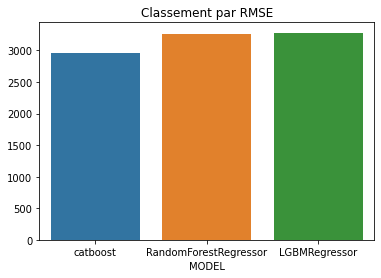

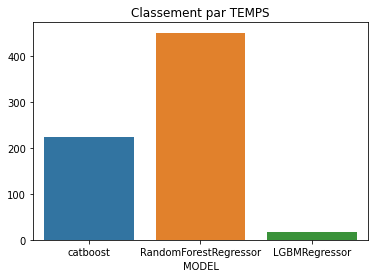

In [ ]:
sns.barplot(x=pprmse["MODEL"], y=pprmse["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()
print("\n")
sns.barplot(x=pprmse["MODEL"], y=pprmse["TEMPS(sec)"].values)
plt.title("Classement par TEMPS")
plt.show()

In [ ]:
perf_per_mae = performances.sort_values(by = ["MAE"], ascending = True)

perf_per_mae.head(20)

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
3,2962.71,1526.08,18.80,1900.74,1101.54,11.86,4,catboost,223.24
3,3263.98,1564.81,20.45,1853.93,634.39,11.56,4,RandomForestRegressor,450.89
3,3281.19,1647.47,20.77,3295.91,1391.29,20.57,4,LGBMRegressor,16.15
2,3476.74,1758.12,22.16,1892.77,1099.99,11.75,3,catboost,195.25
2,3797.92,1872.66,24.55,3459.74,1413.97,21.48,3,LGBMRegressor,14.56
3,3803.66,1895.20,23.98,4498.76,2022.75,28.09,4,XGBRegressor,37.08
2,4107.58,1963.38,25.18,2006.36,678.37,12.44,3,RandomForestRegressor,310.04
2,4316.40,2119.66,28.03,4585.03,2067.60,28.47,3,XGBRegressor,29.72
1,5471.69,2242.74,33.21,1824.62,1060.41,11.44,2,catboost,176.69
1,5767.71,2274.11,34.88,2263.17,690.28,14.18,2,RandomForestRegressor,218.94


Les perfs dans le test, en prenant en compte MAE et RMSE ne changent pas l'ordre de qualité des modèles. Le meilleur modèle niveau performance est le catboost suivi du RandomForest et du Lgbm. Toutefois par soucis de ressources computationnelles, on va préférer le lgbm qui consomme moins de temps à fournir les estimations.

La 2e remarque est que globalement, les pires performances des modèles sont lorsque ces derniers ont moins de données historiques (WIND = 1), et que généralement plus la taille du train set augmente plus les performances s'améliorent.

Et si on comparait avec notre Benchmark ?

In [ ]:
ppbench = perfs.iloc[1:, :].sort_values(by = ["RMSE"], ascending = True)

ppbench = ppbench.reset_index()

ppbench.columns = ['MODEL', 'RMSE', 'MAE', 'RMSE_PCT', 'TEMPS(sec)']

ppbench

,MODEL,RMSE,MAE,RMSE_PCT,TEMPS(sec)
0,catboost,3426.70,1732.89,21.76,227.158201
1,LGBMRegressor,3778.99,1862.99,24.34,18.890098
2,RandomForestRegressor,4071.48,1938.84,24.93,336.882647
3,XGBRegressor,4214.06,2084.48,27.18,51.709990


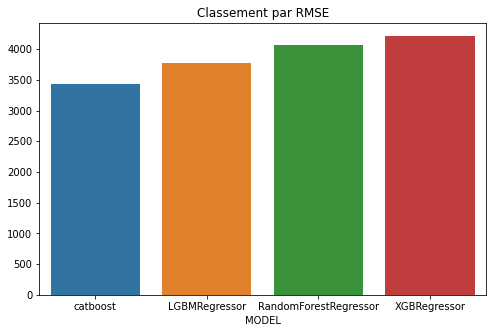

In [ ]:
plt.figure(figsize = (8, 5))
sns.barplot(x = ppbench["MODEL"], y = ppbench["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()

On fait nettement mieux que le Benchmark, les RMSE y sont plus élevées.




In [ ]:
#Maintenant on va prendre notre meilleur modèle (Lgbm) et essayer de trouver les meilleurs hyperparamètres sur la période WIND = 4

In [ ]:
def Lgbm():
  
  importance_df = pd.DataFrame()
  stores = df.Store.unique()

  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()
  for store in stores:
    df_ = df[df['Store']==store]
    train = df_.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois (Début 2010 à Juin 2012)

    scaler = MinMaxScaler()
    X_train = train.drop("Weekly_Sales", axis = 1)
    X_train_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns = X_train.columns)

    y_train = train["Weekly_Sales"]

    # Validation Prediction

    test  = df_.loc['2012-07-06':'2012-10-26'] # 6 mois (Juillet 2012 à Déc 2012)


    X_test = test.drop("Weekly_Sales", axis = 1)
    X_test_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns = X_test.columns)
    y_test = test["Weekly_Sales"]

    X_test = X_test.set_index(y_test.index)
    y_test = test["Weekly_Sales"]

      # Train and validate
    #model = model
    
    
    model =  LGBMRegressor()
    
    
    # Fit model
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    pred = pd.DataFrame(test_pred)
    pred = pred.set_index(y_test.index)
    predictions_test = pd.concat([y_test, pred], axis = 1)
    predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
    predictions_test["Store"] = store

    test_pred_train = model.predict(X_train)
    pred_train = pd.DataFrame(test_pred_train)
    pred_train = pred_train.set_index(y_train.index)
    predictions_train = pd.concat([y_train, pred_train], axis = 1)
    predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
    predictions_train["Store"] = store

    d_test = pd.concat([d_test, predictions_test], axis = 0)
    d_train = pd.concat([d_train, predictions_train], axis = 0)

  
    importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_df["importance_"+str(store)] = model.feature_importances_
  
  importance_df["importance"] = np.mean(importance_df[[col for col in importance_df.columns if col!= "features"]], axis = 1)
  importance_df = importance_df[["features", "importance"]]
  t2 = time.time() - t1

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")
  return model, d_test, d_train, importance_df, t2

model_, d_test_, d_train_, importance_df_, t2_ = Lgbm()

Succès !
L'opération a duré 15.89 sec


 -------> RMSE
 <--> Train : 3295.91
 <--> Test  : 3281.19


 -------> MAE
 <--> Train : 1391.29
 <--> Test  : 1647.47


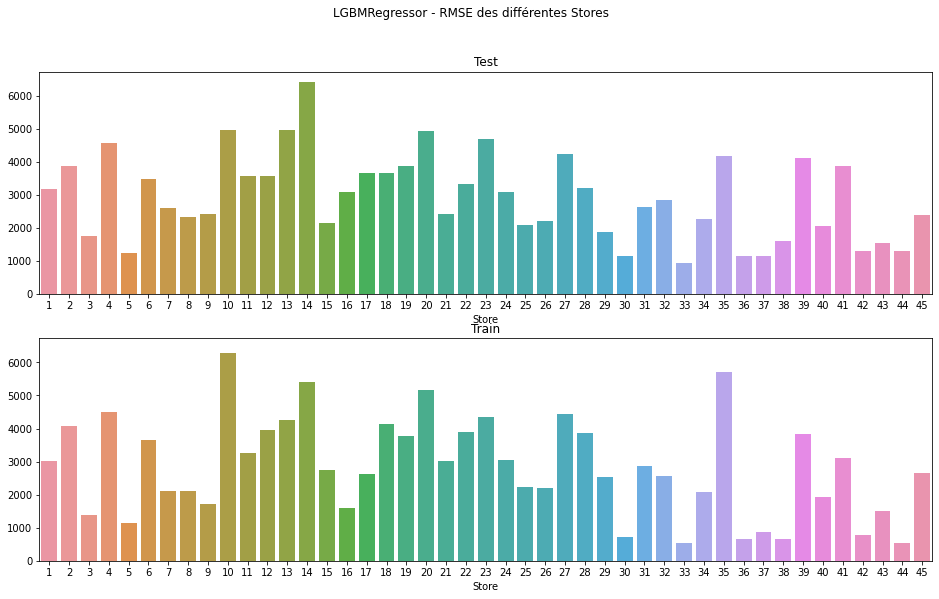

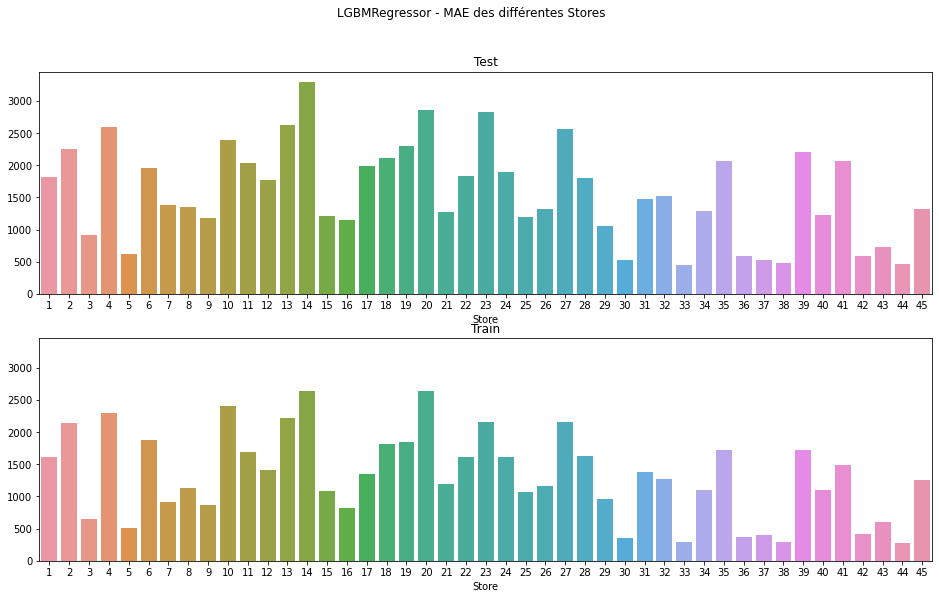

In [ ]:
metrics__ = metrics_(d_test_, d_train_)
plot_metrics(metrics__, model_)

 ---- Features Importance


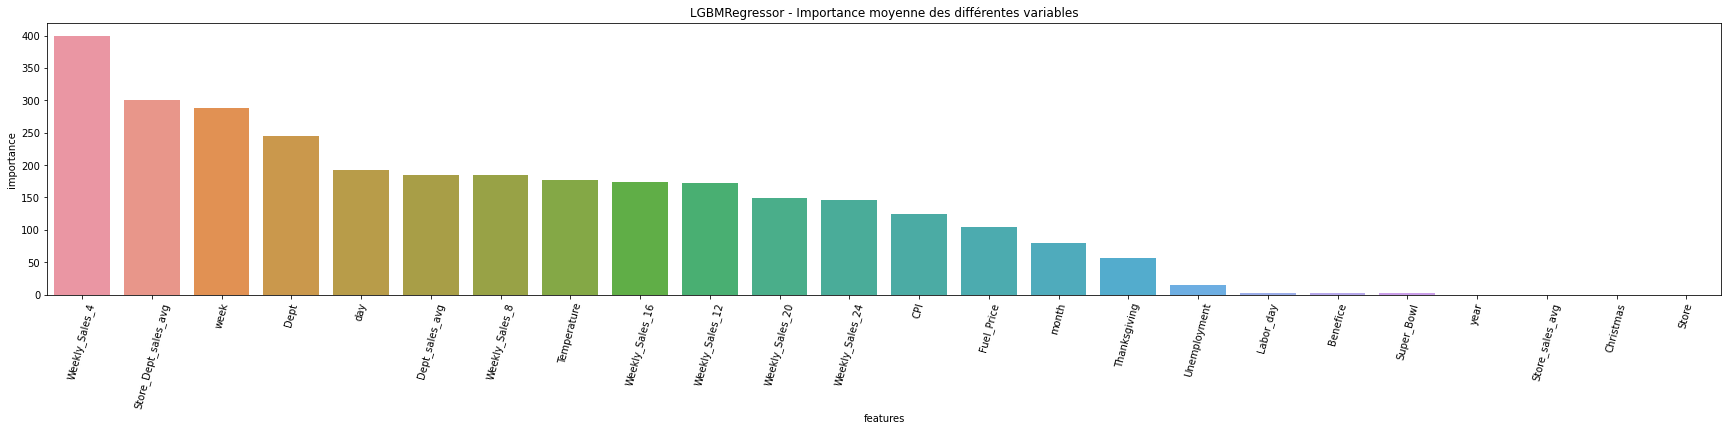

In [ ]:
# Meilleur modèle 
imp_plot(importance_df_, model_)

 ---- Features Importance


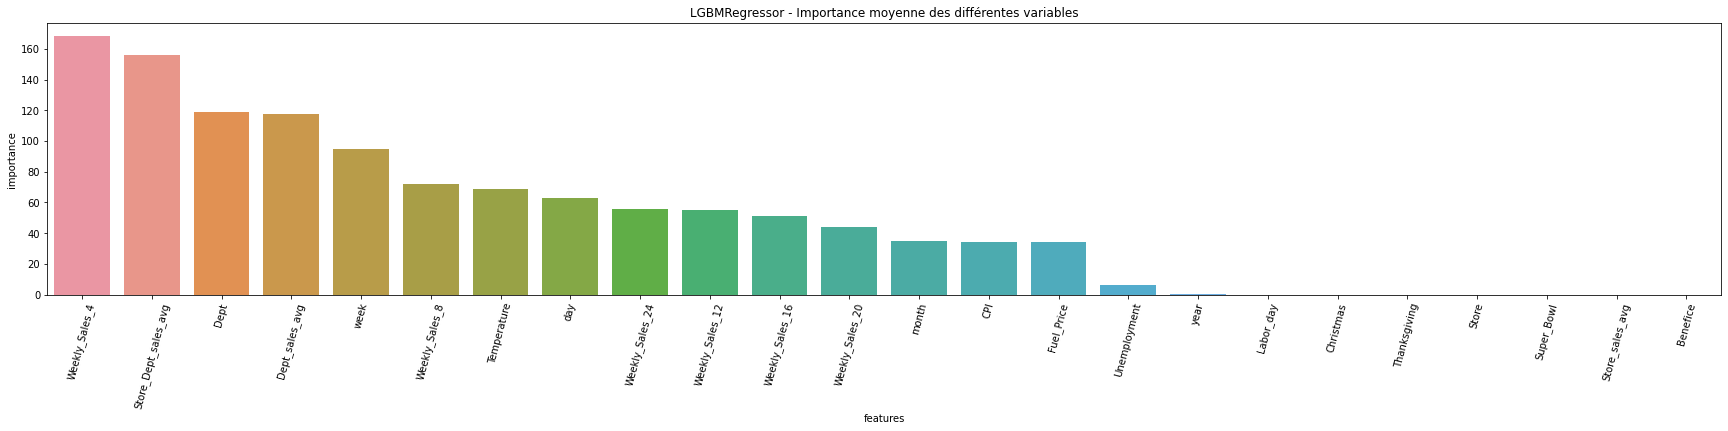

In [ ]:
# Le modèle Benchmark
imp_plot(importance_df_lgbm, model_lgbm)

# 11 - Synthèse et conclusions, pistes d’améliorations envisagées